In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| include: false
import numpy as np
import torch
import torch.nn as nn
from fasterai.sparse.all import *
from fastai.vision.all import *

In [ ]:
#| include: false
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

A sparse vector, as opposed to a dense one, is a vector which contains a lot of zeroes. When we speak about making a neural network sparse, we thus mean that the network's weight are mostly zeroes.

With fasterai, you can do that thanks to the `Sparsifier` class.

Let's start by creating a model

In [ ]:
model = resnet18()

As you probably know, weights in a convolutional neural network have 4 dimensions ($ c_{out} \times c_{in} \times k_h \times k_w$)

In [ ]:
model.conv1.weight.ndim

4

In [ ]:
#| include: false
def plot_kernels(layer, save=None):
    kernels = abs(layer.weight.detach().clone())
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.)
    img = make_grid(kernels, nrow=8, padding=1, pad_value=0.137)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

In the case of ResNet18, the dimension of the first layer weights is $64 \times 3 \times 7 \times 7$. We thus can plot each of the $64$ filter as a $7 \times 7$ color image (because they contains $3$ channels).

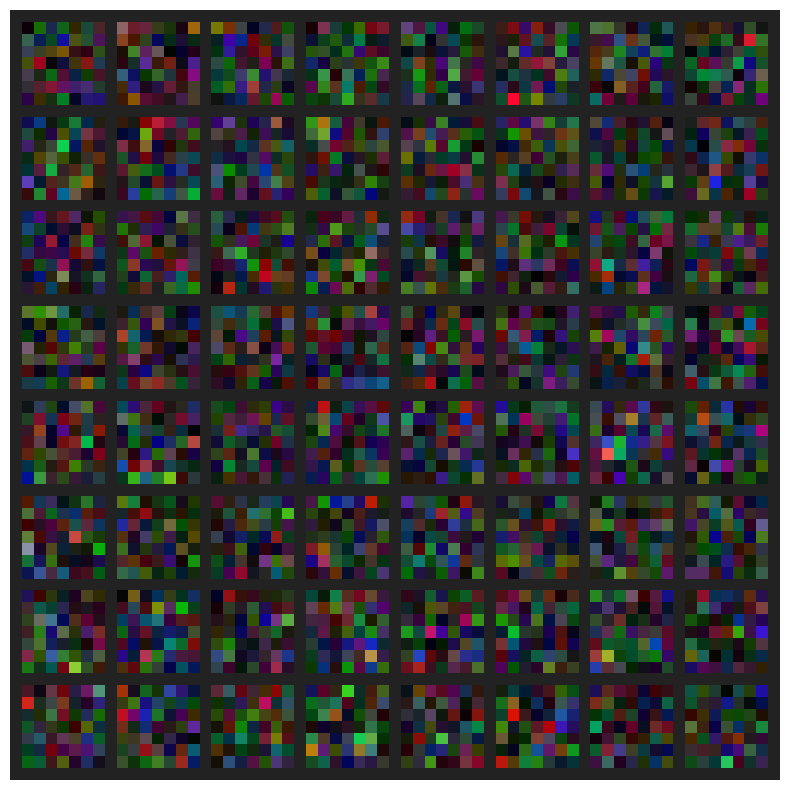

In [ ]:
plot_kernels(model.conv1)

The `Sparsifier` class allows us to remove some (part of) the filters, that are considered to be less useful than others. This can be done by first creating an instance of the class, specifying:

- The `granularity`, i.e. the part of filters that you want to remove. Typically, we usually remove weights, vectors, kernels or even complete filters.
- The `context`, i.e. if you want to consider each layer independently (`local`), or compare the parameters to remove across the whole network (`global`).
- The `criteria`, i.e. the way to assess the usefulness of a parameter. Common methods compare parameters using their magnitude, the lowest magnitude ones considered to be less useful.

User can pass a single layer to prune by using the  `Sparsifier.sparsify_layer` method.

In [ ]:
show_doc(Sparsifier.sparsify_layer)

Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/sparse/sparsifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Sparsifier.sparsify_layer

```python

def sparsify_layer(
    m:nn.Module, # The layer to sparsify
    sparsity:float, # Target sparsity level (percentage)
    round_to:Optional[int]=None, # Round to a multiple of this value
)->None:


```

*Apply sparsification to a single layer*

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'filter', 'local', large_final)
sparsifier.sparsify_layer(model.conv1, 70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      6,615         70.31%
layer1.0.conv1                 Conv2d          36,864     0              0.00%
layer1.0.conv2                 Conv2d          36,864     0              0.00%
layer1.1.conv1                 Conv2d          36,864     0              0.00%
layer1.1.conv2                 Conv2d          36,864     0              0.00%
layer2.0.conv1                 Conv2d          73,728     0              0.00%
layer2.0.conv2                 Conv2d          147,456    0              0.00%
layer2.0.downsample.0          Conv2d          8,192      0              0.00%
layer2.1.conv1                 Conv2d          147,456    0              0.00%
layer2.1.conv2               

Most of the time, we may want to prune the whole model at once, using the `Sparsifier.sparsify_model` method, indicating the percentage of sparsity to you want to apply.

In [ ]:
show_doc(Sparsifier.sparsify_model)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/sparse/sparsifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Sparsifier.sparsify_model

```python

def sparsify_model(
    sparsity:Union[float, dict], # Target sparsity level or per-layer dict
    round_to:Optional[int]=None, # Round to a multiple of this value
)->None:


```

*Apply sparsification to all matching layers in the model*

There are several ways in which we can make that first layer sparse. You will find the most important below:

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'local', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      6,585         69.99%
layer1.0.conv1                 Conv2d          36,864     25,805        70.00%
layer1.0.conv2                 Conv2d          36,864     25,805        70.00%
layer1.1.conv1                 Conv2d          36,864     25,805        70.00%
layer1.1.conv2                 Conv2d          36,864     25,805        70.00%
layer2.0.conv1                 Conv2d          73,728     51,609        70.00%
layer2.0.conv2                 Conv2d          147,456    103,219       70.00%
layer2.0.downsample.0          Conv2d          8,192      5,734         70.00%
layer2.1.conv1                 Conv2d          147,456    103,219       70.00%
layer2.1.conv2               

You now have a model that is $70\%$ sparse ! 

## Granularity

As we said earlier, the `granularity` defines the structure of parameter that you will remove.

In the example below, we removed `weight` from each convolutional filter, meaning that we now have sparse filters, as can be seen in the image below:

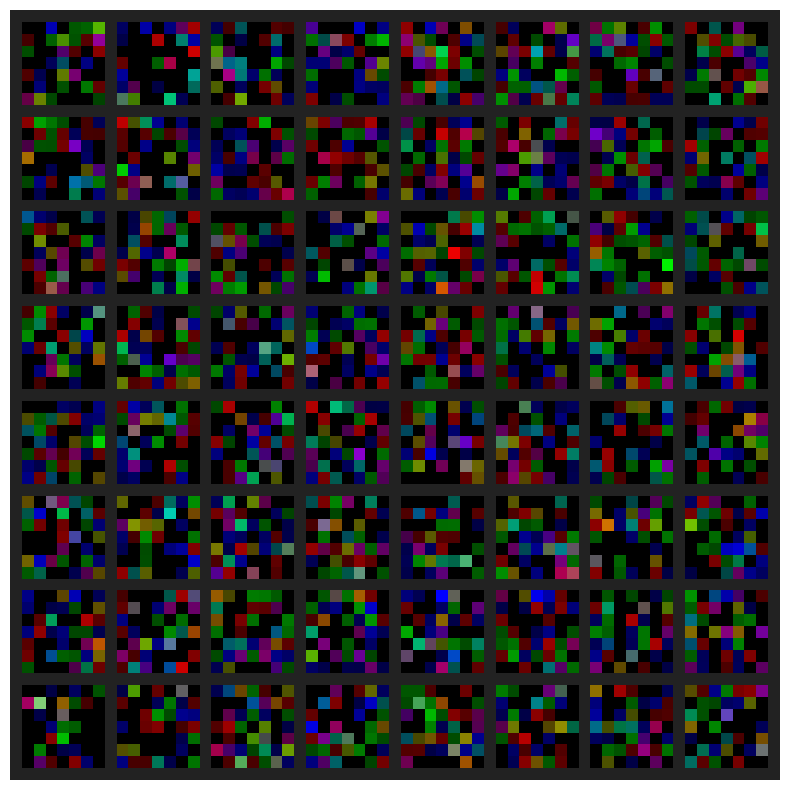

In [ ]:
plot_kernels(model.conv1)

Another granularity is, for example, removing `column` vectors from the filters. To do so, just change the granularity parameter accordingly.

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'column', 'local', large_final)
sparsifier.sparsify_layer(model.conv1, 70)

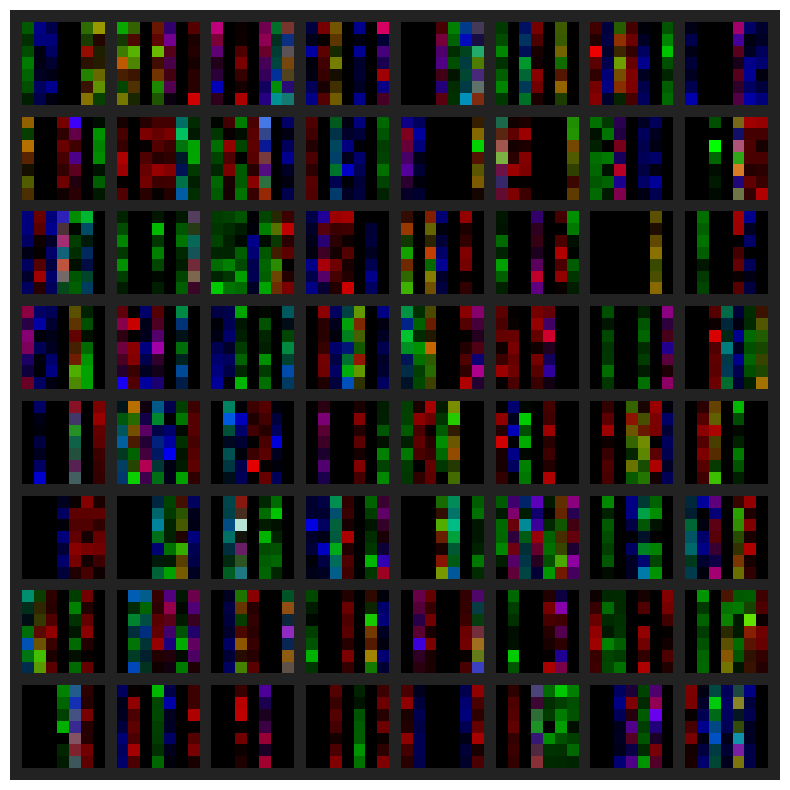

In [ ]:
plot_kernels(model.conv1)

For more information and examples about the pruning granularities, I suggest you to take a look at the [corresponding section](https://nathanhubens.github.io/fasterai/granularity.html).

## Context

The context defines where to look in the model, i.e. from where do we compare weight. The two basic contexts are:
* local, i.e. we compare weight from each layer individually. This will lead to layers with similar levels of sparsity.
* global, i.e. we compare weight from the whole model. This will lead to layers with different levels of sparsity

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'local', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      6,585         69.99%
layer1.0.conv1                 Conv2d          36,864     25,805        70.00%
layer1.0.conv2                 Conv2d          36,864     25,805        70.00%
layer1.1.conv1                 Conv2d          36,864     25,805        70.00%
layer1.1.conv2                 Conv2d          36,864     25,805        70.00%
layer2.0.conv1                 Conv2d          73,728     51,609        70.00%
layer2.0.conv2                 Conv2d          147,456    103,219       70.00%
layer2.0.downsample.0          Conv2d          8,192      5,734         70.00%
layer2.1.conv1                 Conv2d          147,456    103,219       70.00%
layer2.1.conv2               

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'global', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      6,214         66.05%
layer1.0.conv1                 Conv2d          36,864     11,786        31.97%
layer1.0.conv2                 Conv2d          36,864     11,864        32.18%
layer1.1.conv1                 Conv2d          36,864     11,806        32.03%
layer1.1.conv2                 Conv2d          36,864     11,831        32.09%
layer2.0.conv1                 Conv2d          73,728     32,757        44.43%
layer2.0.conv2                 Conv2d          147,456    64,894        44.01%
layer2.0.downsample.0          Conv2d          8,192      1,234         15.06%
layer2.1.conv1                 Conv2d          147,456    64,982        44.07%
layer2.1.conv2               

## Criteria

The `criteria` defines how we select the parameters to remove. It is usually given by a scoring method. The most common one is the `large_final`, i.e. select parameters with the highest absolute value as they are supposed to contribute the most to the final results of the model.

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'global', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      6,325         67.23%
layer1.0.conv1                 Conv2d          36,864     11,915        32.32%
layer1.0.conv2                 Conv2d          36,864     11,815        32.05%
layer1.1.conv1                 Conv2d          36,864     11,965        32.46%
layer1.1.conv2                 Conv2d          36,864     11,990        32.52%
layer2.0.conv1                 Conv2d          73,728     32,395        43.94%
layer2.0.conv2                 Conv2d          147,456    65,275        44.27%
layer2.0.downsample.0          Conv2d          8,192      1,279         15.61%
layer2.1.conv1                 Conv2d          147,456    64,888        44.00%
layer2.1.conv2               

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'global', small_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      9,407         99.99%
layer1.0.conv1                 Conv2d          36,864     456            1.24%
layer1.0.conv2                 Conv2d          36,864     327            0.89%
layer1.1.conv1                 Conv2d          36,864     435            1.18%
layer1.1.conv2                 Conv2d          36,864     905            2.45%
layer2.0.conv1                 Conv2d          73,728     4,653          6.31%
layer2.0.conv2                 Conv2d          147,456    6,854          4.65%
layer2.0.downsample.0          Conv2d          8,192      8              0.10%
layer2.1.conv1                 Conv2d          147,456    6,538          4.43%
layer2.1.conv2               

For more information and examples about the pruning criteria, I suggest you to take a look at the [corresponding section](https://nathanhubens.github.io/fasterai/criteria.html).

## Remark

In some case, you may want to impose the remaining amount of parameters to be a multiple of 8, this can be done by passing the `round_to` parameter.

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'filter', 'local', large_final)
sparsifier.sparsify_model(70, round_to=8)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      5,880         62.50%
layer1.0.conv1                 Conv2d          36,864     23,040        62.50%
layer1.0.conv2                 Conv2d          36,864     23,040        62.50%
layer1.1.conv1                 Conv2d          36,864     23,040        62.50%
layer1.1.conv2                 Conv2d          36,864     23,040        62.50%
layer2.0.conv1                 Conv2d          73,728     50,688        68.75%
layer2.0.conv2                 Conv2d          147,456    101,376       68.75%
layer2.0.downsample.0          Conv2d          8,192      5,632         68.75%
layer2.1.conv1                 Conv2d          147,456    101,376       68.75%
layer2.1.conv2               

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'filter', 'global', large_final)
sparsifier.sparsify_model(70, round_to=8)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      8,232         87.50%
layer1.0.conv1                 Conv2d          36,864     0              0.00%
layer1.0.conv2                 Conv2d          36,864     0              0.00%
layer1.1.conv1                 Conv2d          36,864     0              0.00%
layer1.1.conv2                 Conv2d          36,864     0              0.00%
layer2.0.conv1                 Conv2d          73,728     69,120        93.75%
layer2.0.conv2                 Conv2d          147,456    138,240       93.75%
layer2.0.downsample.0          Conv2d          8,192      0              0.00%
layer2.1.conv1                 Conv2d          147,456    138,240       93.75%
layer2.1.conv2               

For more information about granularities at which you can operate, please check the [related page](https://nathanhubens.github.io/fasterai/granularity.html).

---

## Summary

| Tool | Purpose |
|------|---------|
| `Sparsifier` | Core class for zeroing out weights |
| `sparsify_model()` | Apply sparsification to all matching layers |
| `sparsify_layer()` | Apply sparsification to a single layer |
| `print_sparsity()` | Report per-layer sparsity statistics |
| `large_final` | Criteria: keep weights with largest magnitude |
| Granularity options | `weight`, `vector`, `kernel`, `filter` |
| Context options | `local` (per-layer) vs `global` (network-wide) |

## See Also

- [Sparsifier API](../../sparse/sparsifier.html) - Full Sparsifier API reference
- [SparsifyCallback](../../sparse/sparsify_callback.html) - Integrate sparsification into training
- [Schedules](../../core/schedules.html) - Control sparsification progression
- [Criteria](../../core/criteria.html) - All importance scoring methods
- [Granularity](../../core/granularity.html) - What gets sparsified at each level